In [41]:
from IPython.display import display
import pandas as pd
import numpy as np
import os
from os import listdir
from os import path

import bs4 as bs
import requests
import pickle

import datetime as dt
import pandas_datareader.data as pdr
from tqdm import tqdm
from iexfinance.stocks import get_historical_data
from iexfinance.stocks import Stock

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from ta.momentum import *
from ta.trend import *
from ta.volume import *
from ta.others import *
from ta.volatility import *
import warnings
warnings.filterwarnings('ignore')

sns.set()
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.2)
API_TOKEN = 'pk_248b202c0449443384770697855b70c5'
os.environ["IEX_TOKEN"] = API_TOKEN

In [52]:
aaple = Stock('AAPL')
aaple.get_peers()

['HPQ', 'MSFT', 'IBM', 'GOOGL']

In [11]:
data_path = 'data/'

In [39]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.rstrip('\r\n'))

    with open("data/sp500_tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    return tickers

def load_sp500_tickers():
    try:
        with open("data/sp500_tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    except:
        tickers = save_sp500_tickers()
    return tickers


In [121]:
def macd(close, fast=12, slow=26, signal=9):
    ma_fast = close.ewm(span=fast, min_periods=fast).mean()
    ma_slow = close.ewm(span=slow, min_periods=slow).mean()
    macd_ = ma_fast - ma_slow
    ma_signal = macd_.ewm(span=signal, min_periods=signal).mean()
    return (macd_, ma_signal)

def RSI(close, interval=14):
    """
    Momentum indicator
    As per https://www.investopedia.com/terms/r/rsi.asp
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )
    E.g. if period==6, first RSI starts from 7th index because difference of first row is NA
    http://cns.bu.edu/~gsc/CN710/fincast/Technical%20_indicators/Relative%20Strength%20Index%20(RSI).htm
    https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
    Verified!
    """
    delta = close - close.shift(1)
    gain = (delta > 0) * delta
    loss = (delta < 0) * -delta
    avg_gain = gain.rolling(interval).sum() / interval
    avg_loss = loss.rolling(interval).sum() / interval
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def IBR(close, low, high):
    return (close - low) / (high - low)

def WilliamR(close, low, high, interval=14):
    """
    Momentum indicator
    Using TA Libraray
    %R = (Highest High - Close)/(Highest High - Lowest Low) * -100
    """
    return wr(high, low, close, interval, fillna=True)

def MFI(close, low, high, vol, interval=14):
    """
    Momentum type indicator
    """
    return money_flow_index(high, low, close, vol, n=interval, fillna=True)

def calculate_roc(series, period):
    return ((series.iloc[-1] - series.iloc[0]) / series.iloc[0]) * 100

def ROC(close, interval=14):
    """
    Momentum oscillator
    As per implement https://www.investopedia.com/terms/p/pricerateofchange.asp
    https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
    ROC = (close_price_n - close_price_(n-1) )/close_price_(n-1) * 100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    # for 12 day period, 13th day price - 1st day price
    return close.rolling(interval + 1).apply(calculate_roc, args=(interval,), raw=False)

def CMF(close, low, high, vol, interval=21):
    """
    An oscillator type indicator & volume type
    No other implementation found
    """
    return chaikin_money_flow(high, low, close, vol, interval, fillna=True)

def calculate_cmo(series, period):
    # num_gains = (series >= 0).sum()
    # num_losses = (series < 0).sum()
    sum_gains = series[series >= 0].sum()
    sum_losses = np.abs(series[series < 0].sum())
    cmo = 100 * ((sum_gains - sum_losses) / (sum_gains + sum_losses))
    return np.round(cmo, 3)

def CMO(close, interval=20):
    """
    Chande Momentum Oscillator
    As per https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
    CMO = 100 * ((Sum(ups) - Sum(downs))/ ( (Sum(ups) + Sum(downs) ) )
    range = +100 to -100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    diff = close.diff()[1:]  # skip na
    return diff.rolling(interval).apply(calculate_cmo, args=(interval,), raw=False)

def SMA(close, interval=9):
    """
    Momentum indicator
    """
    return close.rolling(interval).mean()

def EMA(close, interval=9):
    """
    Momentum indicator
    """
    return close.ewm(span=interval, min_periods=interval-1).mean()

def wavg(rolling_prices, period):
    weights = pd.Series(range(1, period + 1))
    return np.multiply(rolling_prices.values, weights.values).sum() / weights.sum()

def WMA(close, interval=9, hma_step=0):
    """
    Momentum indicator
    """
    return close.rolling(interval).apply(wavg, args=(interval,), raw=False)

def TRIX(close, interval=15):
    """
    Shows the percent rate of change of a triple exponentially smoothed moving average.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:trix
    TA lib actually calculates percent rate of change of a triple exponentially
    smoothed moving average not Triple EMA.
    Momentum indicator
    Need validation!
    """
    return trix(close, interval, fillna=True)

def CCI(close, low, high, interval=20):
    """
    Commodity Channel Index (CCI)
    CCI measures the difference between a security’s price change and its average 
    price change. High positive readings indicate that prices are well above their 
    average, which is a show of strength. Low negative readings indicate that 
    prices are well below their average, which is a show of weakness.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci
    """
    return cci(high, low, close, interval, fillna=True)

def DPO(close, interval=20):
    """
    Detrended Price Oscillator (DPO)
    Is an indicator designed to remove trend from price and make it easier to 
    identify cycles.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:detrended_price_osci    
    """
    return dpo(close, n=interval)

def KST(close, interval=20):
    """
    KST Oscillator (KST Signal)
    It is useful to identify major stock market cycle junctures because its 
    formula is weighed to be more greatly influenced by the longer and more 
    dominant time spans, in order to better reflect the primary swings of stock 
    market cycle.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:know_sure_thing_kst  """
    return kst(close, interval)

def DMI(close, low, high, interval=14):
    """
    Average Directional Movement Index (ADX)
    The Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI) are 
    derived from smoothed averages of these differences, and measure trend direction 
    over time. These two indicators are often referred to collectively as the 
    Directional Movement Indicator (DMI).
    The Average Directional Index (ADX) is in turn derived from the smoothed 
    averages of the difference between +DI and -DI, and measures the strength 
    of the trend (regardless of direction) over time.
    Using these three indicators together, chartists can determine both the 
    direction and strength of the trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx
    """
    return adx(high, low, close, n=interval, fillna=True)

def BB_MAV(close, interval=20):
    """
    Bollinger Bands (BB)
    N-period simple moving average (MA).
    https://en.wikipedia.org/wiki/Bollinger_Bands
    """
    return bollinger_mavg(close, n=interval, fillna=True)

def FI(close, vol, interval=13):
    """
    Force Index (FI)
    It illustrates how strong the actual buying or selling pressure is. 
    High positive values mean there is a strong rising trend, and low 
    values signify a strong downward trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:force_index
    """
    return force_index(close, vol, n=interval, fillna=True)

def EOM(low, high, vol, interval=14):
    """
    An Oscillator type indicator and volume type
    Ease of Movement : https://www.investopedia.com/terms/e/easeofmovement.asp
    """
    dm = (high + low) / 2 - (high.shift(1) - low.shift(1)) / 2
    br = vol / (high - low)
    evm = dm / br
    return evm.rolling(interval).mean()

In [109]:
def add_techincal_indicators(input_data):

    close = input_data['close']
    high = input_data['high']
    low = input_data['low']
    vol = input_data['volume']
    adj_close = input_data['adj close']

    input_data = input_data[['open', 'close', 'high', 'low', 'volume']]
    input_data['macd'], input_data['signal'] = macd(close)
    input_data['rsi']     = RSI(close=close)
    input_data['ibr']     = IBR(close=close, low=low, high=high)
    input_data['willamr'] = WilliamR(close=close, low=low, high=high)
    input_data['mfi']     = MFI(close=close, low=low, high=high, vol=vol)
    input_data['roc_12']  = ROC(close=close, interval=12)
    input_data['roc_25']  = ROC(close=close, interval=25)
    input_data['cmf']     = CMF(close=close, low=low, high=high, vol=vol)
    input_data['cmo']     = CMO(close=close)
    input_data['sma']     = SMA(close=close)
    input_data['ema']     = EMA(close=close)
    input_data['wma']     = WMA(close=close)
    input_data['trix']    = TRIX(close=close)
    input_data['cci']     = CCI(close=close, low=low, high=high)
    input_data['dpo']     = DPO(close=close)
    input_data['kst']     = KST(close=close)
    input_data['dmi']     = DMI(close=close, low=low, high=high)
    input_data['bb']      = BB_MAV(close=close)
    input_data['fi']      = FI(close=close, vol=vol)
    input_data['eom']     = EOM(low=low, high=high, vol=vol)
    return input_data

In [95]:
tickers = load_sp500_tickers()

In [55]:
tickers = load_sp500_tickers()
peers = []
for i, ticker in enumerate(tickers):
    peers.append(Stock(ticker).get_peers())
    print (i, ticker)
peers_df = pd.DataFrame({'tickers':tickers, 'peers':peers})

0 MMM
1 ABT
2 ABBV
3 ABMD
4 ACN
5 ATVI
6 ADBE
7 AMD
8 AAP
9 AES
10 AFL
11 A
12 APD
13 AKAM
14 ALK
15 ALB
16 ARE
17 ALXN
18 ALGN
19 ALLE
20 ADS
21 LNT
22 ALL
23 GOOGL
24 GOOG
25 MO
26 AMZN
27 AMCR
28 AEE
29 AAL
30 AEP
31 AXP
32 AIG
33 AMT
34 AWK
35 AMP
36 ABC
37 AME
38 AMGN
39 APH
40 ADI
41 ANSS
42 ANTM
43 AON
44 AOS
45 APA
46 AIV
47 AAPL
48 AMAT
49 APTV
50 ADM
51 ANET
52 AJG
53 AIZ
54 T
55 ATO
56 ADSK
57 ADP
58 AZO
59 AVB
60 AVY
61 BKR
62 BLL
63 BAC
64 BK
65 BAX
66 BDX
67 BRK.B
68 BBY
69 BIIB
70 BLK
71 BA
72 BKNG
73 BWA
74 BXP
75 BSX
76 BMY
77 AVGO
78 BR
79 BF.B
80 CHRW
81 COG
82 CDNS
83 CPB
84 COF
85 CAH
86 KMX
87 CCL
88 CARR
89 CAT
90 CBOE
91 CBRE
92 CDW
93 CE
94 CNC
95 CNP
96 CTL
97 CERN
98 CF
99 SCHW
100 CHTR
101 CVX
102 CMG
103 CB
104 CHD
105 CI
106 CINF
107 CTAS
108 CSCO
109 C
110 CFG
111 CTXS
112 CLX
113 CME
114 CMS
115 KO
116 CTSH
117 CL
118 CMCSA
119 CMA
120 CAG
121 CXO
122 COP
123 ED
124 STZ
125 COO
126 CPRT
127 GLW
128 CTVA
129 COST
130 COTY
131 CCI
132 CSX
133 CMI
134 CVS
1

In [60]:
display(peers_df)
peers_df.to_csv(data_path + "/peers.csv")
min_list = 100
for peer_list in peers:
    if (len(peer_list) < min_list):
        min_list = len(peer_list)
        print (min_list)

,tickers,peers
0,MMM,"[HON, DHR, GE, ITW, JNJ, XRAY, AMZN, HPQ, ALGN..."
1,ABT,"[JNJ, PFE, HOLX, MDT, TMO, BMY, MYL, BSX, AZN,..."
2,ABBV,"[PFE, BMY, LLY, AMGN, GILD, BIIB, GSK, AZN, NBIX]"
3,ABMD,"[TFX, BSX, ATRC, STXS]"
4,ACN,"[CTSH, IBM, INFY, WIT, NOK, ERIC, EBAY, SAP, X..."
...,...,...
500,YUM,"[MCD, DPZ, WEN, DRI, CMG, SBUX, JACK, CBRL, AR..."
501,ZBRA,"[HPQ, XRX, CAJ, ALOT, HON, DHR, TACT, HTHIY, B..."
502,ZBH,"[BSX, COO, SYK, EW]"
503,ZION,"[GBCI, WAL, USB, NBHC, FIBK, PMBC]"


10
9
4
3
0


In [62]:
peer_df = pd.read_csv(data_path + "/peers.csv", index_col=0)
display(peer_df)
Stock('CARR').get_peers()

,tickers,peers
0,MMM,"['HON', 'DHR', 'GE', 'ITW', 'JNJ', 'XRAY', 'AM..."
1,ABT,"['JNJ', 'PFE', 'HOLX', 'MDT', 'TMO', 'BMY', 'M..."
2,ABBV,"['PFE', 'BMY', 'LLY', 'AMGN', 'GILD', 'BIIB', ..."
3,ABMD,"['TFX', 'BSX', 'ATRC', 'STXS']"
4,ACN,"['CTSH', 'IBM', 'INFY', 'WIT', 'NOK', 'ERIC', ..."
...,...,...
500,YUM,"['MCD', 'DPZ', 'WEN', 'DRI', 'CMG', 'SBUX', 'J..."
501,ZBRA,"['HPQ', 'XRX', 'CAJ', 'ALOT', 'HON', 'DHR', 'T..."
502,ZBH,"['BSX', 'COO', 'SYK', 'EW']"
503,ZION,"['GBCI', 'WAL', 'USB', 'NBHC', 'FIBK', 'PMBC']"


[]

In [98]:
for i, ticker in enumerate(tickers):
    print(str(int(i / 50)) + " " + ticker)

0 MMM
0 ABT
0 ABBV
0 ABMD
0 ACN
0 ATVI
0 ADBE
0 AMD
0 AAP
0 AES
0 AFL
0 A
0 APD
0 AKAM
0 ALK
0 ALB
0 ARE
0 ALXN
0 ALGN
0 ALLE
0 ADS
0 LNT
0 ALL
0 GOOGL
0 GOOG
0 MO
0 AMZN
0 AMCR
0 AEE
0 AAL
0 AEP
0 AXP
0 AIG
0 AMT
0 AWK
0 AMP
0 ABC
0 AME
0 AMGN
0 APH
0 ADI
0 ANSS
0 ANTM
0 AON
0 AOS
0 APA
0 AIV
0 AAPL
0 AMAT
0 APTV
1 ADM
1 ANET
1 AJG
1 AIZ
1 T
1 ATO
1 ADSK
1 ADP
1 AZO
1 AVB
1 AVY
1 BKR
1 BLL
1 BAC
1 BK
1 BAX
1 BDX
1 BRK.B
1 BBY
1 BIIB
1 BLK
1 BA
1 BKNG
1 BWA
1 BXP
1 BSX
1 BMY
1 AVGO
1 BR
1 BF.B
1 CHRW
1 COG
1 CDNS
1 CPB
1 COF
1 CAH
1 KMX
1 CCL
1 CARR
1 CAT
1 CBOE
1 CBRE
1 CDW
1 CE
1 CNC
1 CNP
1 CTL
1 CERN
1 CF
1 SCHW
2 CHTR
2 CVX
2 CMG
2 CB
2 CHD
2 CI
2 CINF
2 CTAS
2 CSCO
2 C
2 CFG
2 CTXS
2 CLX
2 CME
2 CMS
2 KO
2 CTSH
2 CL
2 CMCSA
2 CMA
2 CAG
2 CXO
2 COP
2 ED
2 STZ
2 COO
2 CPRT
2 GLW
2 CTVA
2 COST
2 COTY
2 CCI
2 CSX
2 CMI
2 CVS
2 DHI
2 DHR
2 DRI
2 DVA
2 DE
2 DAL
2 XRAY
2 DVN
2 DXCM
2 FANG
2 DLR
2 DFS
2 DISCA
2 DISCK
2 DISH
3 DG
3 DLTR
3 D
3 DPZ
3 DOV
3 DOW
3 DTE
3 DUK
3 DRE
3 DD
3 DXC
3

In [122]:
def get_input_data(ticker, span=20):
    end_date = dt.date.today()
    start_date = end_date - dt.timedelta(365 * span)
    data = pdr.get_data_yahoo(ticker, start_date, end_date)
    data.columns = map(str.lower, data.columns)
    data = add_techincal_indicators(input_data=data)
    data.dropna(inplace=True)
    return data

In [8]:
def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [126]:
def load_data(ticker, bucket):
    today = str(dt.date.today())
    maybe_make_dir(os.path.join(data_path, today))
    maybe_make_dir(os.path.join(data_path, today, bucket))
    csv_file = os.path.join(data_path, today, bucket, ticker + ".csv")
    try:
        data = pd.read_csv(csv_file, header=True, index=True)
    except:
        data = get_input_data(ticker)
        data.to_csv(csv_file, header=True, index=True)
    return data

In [127]:
for i in tqdm(range(len(tickers))):
    try:
        ticker = tickers[i]
        bucket = str(int(i / 50))
        load_data(ticker, bucket)
    except:
        print ("Fail:" + ticker)
        pass

 13%|█▎        | 68/505 [17:44<1:36:50, 13.30s/it]

Fail:BRK.B


 16%|█▌        | 80/505 [20:26<1:01:25,  8.67s/it]

Fail:BF.B


100%|██████████| 505/505 [11:01:02<00:00, 78.54s/it]     


In [91]:
date = '2020-05-16'

In [92]:
results = pd.DataFrame()
for file in listdir(data_path + date + "/results/"):
    results = pd.concat((results, pd.read_csv(data_path + date + "/results/" + file, index_col=0)))
results['trends'] = results['trends'] * 100
results = results.replace([np.inf, -np.inf], np.nan)
results.dropna(inplace=True)


In [93]:
results.describe()

,trading_day,accuracy,trends
count,442.000000,442.000000,442.000000
mean,3.456618,72.632216,-13.500903
std,5.649984,6.884241,251.587940
min,2.269693,50.709220,-5277.899293
25%,2.269693,68.198191,-5.958389
50%,2.269693,73.254181,-2.518077
75%,2.280733,77.742529,0.432813
max,59.649123,85.802469,307.277554


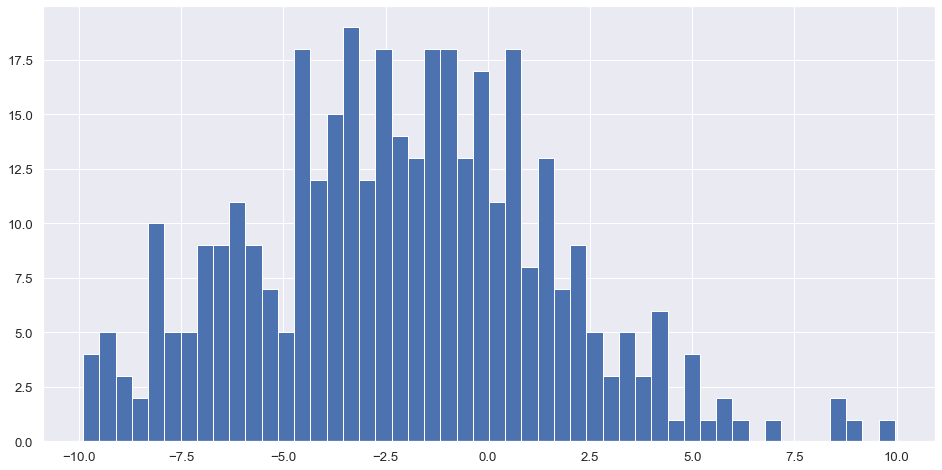

In [94]:
plt.hist(results[(results.trends < 10) & (results.trends > -10)].trends, bins=50)
plt.show()

In [101]:
def find_best_option(results):
    results['abs_trends'] = results['trends'].abs()
    best_options = results[(results['accuracy'] > 80) & (results['trends'] > 2)].sort_values(
        by=['accuracy'], ascending=False).head(10)
    if (best_options.shape[1] < 10):
        best_options = pd.concat((best_options, 
            results[(results['accuracy'] > 70) & (results['accuracy'] < 80) & (results['trends'] > 2)].sort_values(
                by=['trends'], ascending=False).head(10 - best_options.shape[1])))
    return best_options

In [102]:
best_options = find_best_option(results)

In [103]:
def check_today_prediction(best_options):
    tickers = best_options['ticker'].values
    end_date = dt.date.today()
    start_date = end_date - dt.timedelta(3)
    today_trends = []
    for ticker in tickers:
        data = pdr.get_data_yahoo(ticker, start_date, end_date)
        close = data['Close']
        prev_close = close.shift(1)
        #display(data)
        today_trends.append((close[-1] - prev_close[-1]) * 100 / prev_close[-1])
    best_options['today_trend'] = np.array(today_trends)
    return best_options

In [104]:
best_options = check_today_prediction(best_options)

In [105]:
best_options

,ticker,trading_day,accuracy,trends,abs_trends,today_trend
26,VNO,2.269693,85.225718,3.497197,3.497197,-1.082651
29,AAL,3.105023,84.477612,6.062307,6.062307,-2.330289
23,BXP,2.269693,83.048433,2.648836,2.648836,-3.842828
27,KIM,2.269693,82.548794,5.755727,5.755727,0.480309
5,IP,2.269693,81.635389,4.147800,4.147800,-2.408539
37,PSA,2.269693,81.358885,2.345853,2.345853,0.119983
20,ADS,2.399435,80.567376,13.059496,13.059496,-4.862816
43,CTL,2.269693,71.344455,46.843825,46.843825,-1.135187
11,BKR,2.275770,70.833333,34.123296,34.123296,-5.410690
10,CFG,8.173077,71.612903,18.777908,18.777908,-4.216867


In [ ]:
plt.hist()

## Longer Prediction 

In [50]:
tickers = load_sp500_tickers()
for ticker in tickers:
    if path.exists("data/tmp/" + ticker + "_input.out") & path.exists("data/tmp/" + ticker + "_result.out"):
        scaled_input = pd.read_csv("data/tmp/" + ticker + "_input.out", header=None)
        scaled_input.columns = ['open', 'close', 'high', 'low', 'volume', 
                                'macd', 'signal', 'rsi', 'ibr', 'willamr', 
                                'mfi', 'roc_12', 'roc_25', 'cmf', 'cmo', 
                                'sma', 'ema', 'wma', 'trix', 'cci', 'dpo', 
                                'kst', 'dmi', 'bb', 'fi', 'eom']

        scaled_result = pd.read_csv("data/tmp/" + ticker + "_result.out", header=None)
        scaled_result.columns = ['open', 'close', 'high', 'low', 'volume']

        res = pd.DataFrame({'cl':scaled_input['close'][-len(scaled_result):].values, 
                            'clp':scaled_result['close'].values})
        res.dropna(inplace=True)

        corr = []
        for i in range(1, 20):
            j = str(i)
            res['cl_' + j] = res.cl.shift(i)
            res['m_' + j] = (res.cl - res["cl_" + j]) / res.cl
            res['mp_' + j] = (res.clp - res["cl_" + j]) / res.cl
            res['acc_' + j] = (np.sign(res['m_' + j] * res['mp_' + j]) == 1).astype(int)
            corr.append("{0:6.3f}".format(sum(res['acc_' + j])*100 / len(res)))
        print (ticker, corr[-10:])


MMM ['41.114', '42.105', '43.249', '44.165', '43.936', '43.402', '44.851', '43.707', '44.012', '44.394']
ABT ['69.738', '72.135', '73.034', '75.730', '75.206', '75.955', '78.876', '79.625', '78.577', '78.577']
ABMD ['73.625', '75.584', '76.112', '76.714', '76.262', '77.167', '76.714', '79.277', '80.181', '79.955']
ACN ['76.960', '77.680', '78.560', '79.920', '80.400', '81.040', '81.200', '80.320', '83.200', '82.000']
ATVI ['73.184', '73.408', '73.184', '75.730', '76.030', '76.105', '75.206', '74.607', '74.831', '75.805']
ADBE ['52.285', '53.708', '53.333', '54.532', '53.933', '53.933', '56.479', '55.581', '57.678', '58.577']
AMD ['81.662', '82.335', '82.485', '83.009', '83.159', '83.009', '84.132', '83.308', '84.057', '84.656']
AAP ['66.721', '67.539', '68.847', '69.583', '70.237', '71.954', '72.445', '73.998', '75.143', '75.307']
AES ['66.467', '67.665', '67.141', '68.114', '67.740', '69.237', '70.284', '71.856', '70.958', '72.006']
QCOM ['85.094', '86.442', '84.944', '85.993', '84.79

In [69]:
tickers = load_sp500_tickers()
for ticker in tickers[40:50]:
    if path.exists("data/tmp/" + ticker + "_input.out") & path.exists("data/tmp/" + ticker + "_result.out"):
        scaled_input = pd.read_csv("data/tmp/" + ticker + "_input.out", header=None)
        scaled_result = pd.read_csv("data/tmp/" + ticker + "_result.out", header=None)
        columns = ['close_' + str(i) for i in range(0, 6)]
        scaled_data = scaled_input[1][-len(scaled_result):].values.reshape(scaled_result.values.shape[0], 1)
        res = pd.DataFrame(np.concatenate((scaled_data, scaled_result.values), axis=1), columns=columns)

        corr = []
        for i in range(1, 6):
            j = str(i)
            res['cn_' + j] = res.close_0.shift(-i)
            res['m_' + j] = (res['cn_' + j] - res.close_0) / res.close_0
            res['mp_' + j] = (res['close_' + j] - res.close_0) / res.close_0
            res['acc_' + j] = (np.sign(res['m_' + j] * res['mp_' + j]) == 1).astype(int)
            corr.append("{0:6.3f}".format(sum(res['acc_' + j])*100 / len(res)))
        
        #display(res)
        display(corr)


['50.000', '48.571', '48.195', '49.098', '48.571']

['48.611', '46.487', '45.833', '44.118', '42.565']

['48.234', '50.188', '50.563', '48.234', '52.141']

['44.778', '45.455', '43.727', '41.172', '42.224']

['50.038', '48.009', '46.957', '48.460', '47.934']